# <center>Block Neural Autoregressive Flows [1]</center>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc
import math

from scipy.stats import multivariate_normal
from tqdm.auto import trange
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.multivariate_normal import MultivariateNormal

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### BNAF

In [3]:
## https://github.com/kamenbliznashki/normalizing_flows/blob/master/bnaf.py

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        out = F.linear(x, w, self.bias)
        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()

In [4]:
class BNAF(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

In [5]:
def loss(h,log_det,distr,base_distr="ok"):
    prior = distr.log_prob(h).mean(0)
    log_det = log_det.sum(1).mean(0)
    return -(prior+log_det)


def log_likelihood(h,log_det,distr,base_distr="normal"):
    prior = distr.log_prob(h)
    log_det = log_det.sum(1)
    return prior+log_det

In [6]:
def val_likelihood(model, distr, i, device, base_distr="normal", scatter=False,
                  xmin=-8, xmax=8, ymin=-8, ymax=8):
    model.eval()

    xline = torch.linspace(xmin, xmax, 100)
    yline = torch.linspace(ymin, ymax, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        xy, log_s = model(xyinput.to(device))
#         print(xy.size(), log_s.size())
        zz = (log_likelihood(xy,log_s,distr,base_distr)).exp().cpu()
        zgrid = zz.reshape(100,100)
        
        if scatter:
            z = distr.sample((100,))
            xs = model.backward(z)
            x = xs.detach()
            x = x.cpu().numpy()
            z = z.cpu().numpy()

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.colorbar()
    if scatter:
        plt.scatter(x[:,0],x[:,1],c="red")
        plt.scatter(z[:,0],z[:,1],c="green")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title('iteration {}'.format(i + 1))
    plt.show()

### 8 Gaussians

In [7]:
def create_gaussians(num_points):
    """
        Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py
    """
    scale = 4.
    bias = np.pi / 8
    step = np.pi / 4
    centers = [(np.cos(bias + 0*step), np.sin(bias + 0*step)),
               (np.cos(bias + 1*step), np.sin(bias + 1*step)),
               (np.cos(bias + 2*step), np.sin(bias + 2*step)),
               (np.cos(bias + 3*step), np.sin(bias + 3*step)),
               (np.cos(bias + 4*step), np.sin(bias + 4*step)),
               (np.cos(bias + 5*step), np.sin(bias + 5*step)),
               (np.cos(bias + 6*step), np.sin(bias + 6*step)),
               (np.cos(bias + 7*step), np.sin(bias + 7*step))]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(num_points):
        point = np.random.randn(2) * 0.5
        idx = np.random.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414
    return torch.from_numpy(dataset)

In [8]:
X = create_gaussians(1000)

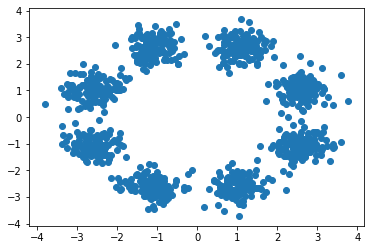

In [9]:
Xnp = X.numpy()
plt.scatter(Xnp[:,0],Xnp[:,1])
plt.show()

In [10]:
def train_8gaussian(model, optimizer, n_epochs=10001, base_distr="normal", d=2, 
                    device=None, plot_val=True, plot_interval=1000,
                    input_grad=False):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if base_distr == "normal":
        distr = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(d,device=device),torch.eye(d,device=device))
    elif base_distr == "logistic":
	    distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
           torch.ones(d, device=device)), SigmoidTransform().inv)
    else:
        raise ValueError("wrong base distribution")

    train_loss = []
    
    pbar = trange(n_epochs)

    for i in pbar: #range(n_epochs):        
        x = torch.tensor(create_gaussians(512), dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
#         print(z.size(), log_det.size())
        l = loss(z,log_det,distr,base_distr)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            pbar.set_postfix_str(f"loss = {train_loss[-1]:.3f}")

        if plot_val and i % plot_interval == 0:
#             print(i, test_dataloader(model,test_loader,base_distr,device)) # train_loss[-1])
            val_likelihood(model, distr, i, device, xmin=-4, xmax=4, ymin=-4, ymax=4)
            
    return train_loss

In [11]:
d = 2

model = BNAF(d, 3, 100).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  31204


/share/common/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/share/common/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


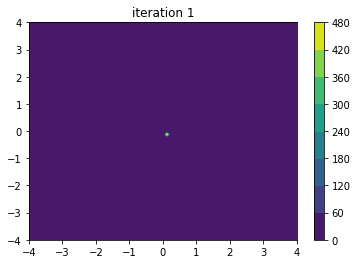

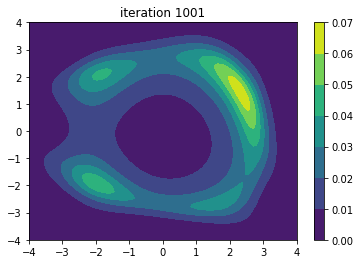

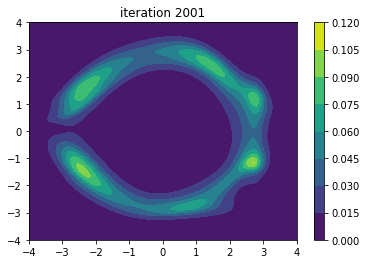

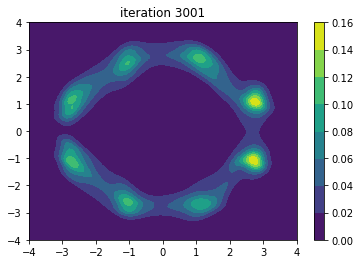

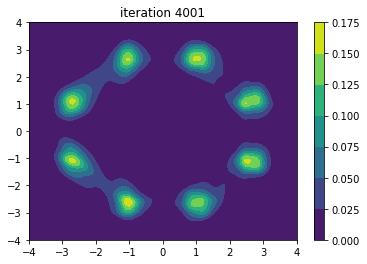

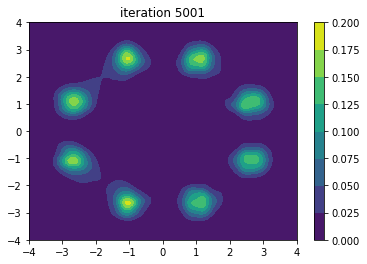

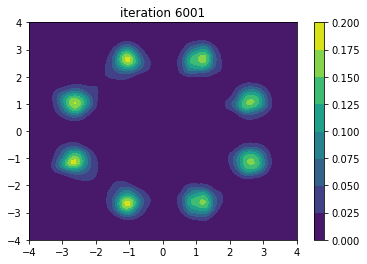

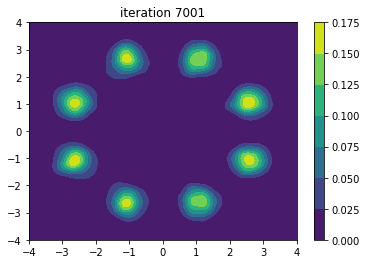

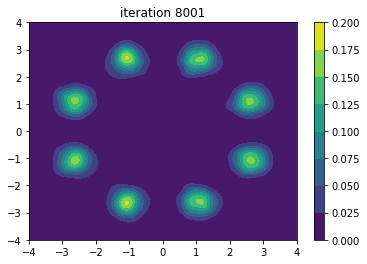

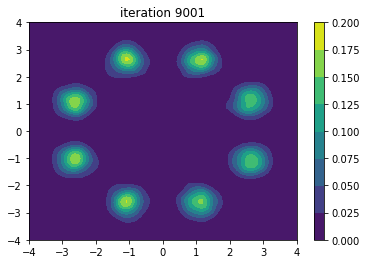

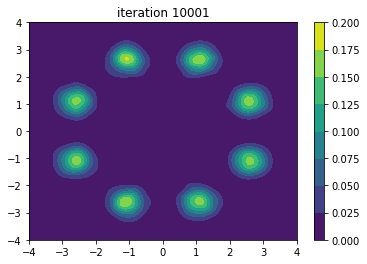

In [12]:
train_loss = train_8gaussian(model, optimizer)

[1] De Cao, Nicola, Wilker Aziz, and Ivan Titov. "Block neural autoregressive flow." Uncertainty in Artificial Intelligence. PMLR, 2020.